# Identifying Transit Deserts with SVI

## Merge Segmentation CSVs and Preprocess Downloaded data 

In [3]:
import pandas as pd
import os

def merge_segmentation_data(root_dir, seg_type):
    """Merges all segmentation CSVs from geoid-based folders into a single DataFrame."""
    df_list = [
        pd.read_csv(os.path.join(root_dir, geoid, file), encoding="ISO-8859-1").assign(geoid=geoid)
        for geoid in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, geoid))
        for file in os.listdir(os.path.join(root_dir, geoid)) if file.endswith(f"{seg_type}.csv")
    ]
    return pd.concat(df_list, ignore_index=True) if df_list else None

def save_merged_data(df, output_file):
    """Saves the merged DataFrame to CSV if not empty."""
    if df is not None:
        df.to_csv(output_file, index=False)
        print(f"Merged file saved at: {output_file}")
    else:
        print(f"No data found for {output_file}.")

# Merge and save segmentation data
root_dir = "/Volumes/MRDALLMAYR/data/mapillary_osm_imgs_segmented"
instance_counts = merge_segmentation_data(root_dir, "label_counts")
pixel_ratios = merge_segmentation_data(root_dir, "pixel_ratios")

save_merged_data(instance_counts, "/Users/etoileboots/Desktop/CAPSTONE/segmentation/all_instance_counts.csv")
save_merged_data(pixel_ratios, "/Users/etoileboots/Desktop/CAPSTONE/segmentation/all_pixel_ratios.csv")


Merged file saved at: /Users/etoileboots/Desktop/CAPSTONE/segmentation/all_instance_counts.csv
Merged file saved at: /Users/etoileboots/Desktop/CAPSTONE/segmentation/all_pixel_ratios.csv


In [4]:
import pandas as pd

def pivot_segmentation_data(df, value_column, output_csv):
    """
    Pivots a segmentation DataFrame so that each label_name becomes a column.
    
    Parameters:
        input_csv (str): Path to the merged CSV file.
        value_column (str): Name of the column containing values to pivot (e.g., 'label_counts' or 'pixel_ratio').
        output_csv (str): Path to save the pivoted DataFrame.
    
    Returns:
        pd.DataFrame: Pivoted DataFrame.
    """
    # Load data

    # Pivot table to reshape data: Each label_name becomes a column
    pivot_df = df.pivot(index=["geoid", "filename_key"], columns="label_name", values=value_column).reset_index()

    # Fill missing values with 0 (if a label wasn't detected in an image, assume count = 0)
    pivot_df = pivot_df.fillna(0)

    # Save pivoted DataFrame
    pivot_df.to_csv(output_csv, index=False)
    print(f"Pivoted file saved as: {output_csv}")

    return pivot_df

instance_pivoted_df = pivot_segmentation_data(instance_counts , "label_counts", "pivoted_instance_counts.csv")
pixel_pivoted_df = pivot_segmentation_data(pixel_ratios, "pixel_ratios", "pivoted_pixel_ratios.csv")

# Preview the pivoted data
print(instance_pivoted_df.head())
print(pixel_pivoted_df.head())


Pivoted file saved as: pivoted_instance_counts.csv
Pivoted file saved as: pivoted_pixel_ratios.csv
label_name        geoid  filename_key  bicycle  building  bus   car  fence  \
0           48201100001  1.152699e+14      0.0       1.0  0.0   8.0    1.0   
1           48201100001  1.239101e+14      0.0       1.0  0.0  11.0    1.0   
2           48201100001  1.282752e+14      0.0       1.0  0.0   5.0    1.0   
3           48201100001  1.300632e+14      0.0       1.0  0.0   2.0    1.0   
4           48201100001  1.313521e+14      0.0       1.0  0.0   7.0    0.0   

label_name  motorcycle  person  pole  ...  road  sidewalk  sky  terrain  \
0                  0.0     0.0   1.0  ...   1.0       1.0  1.0      1.0   
1                  0.0     1.0   1.0  ...   1.0       1.0  1.0      1.0   
2                  0.0     0.0   0.0  ...   1.0       0.0  1.0      0.0   
3                  1.0     1.0   1.0  ...   1.0       1.0  1.0      1.0   
4                  0.0     1.0   1.0  ...   1.0       1.0

In [5]:
import pandas as pd

# Drop non-label columns (geoid and filename_key) for renaming
instance_labels = instance_pivoted_df.drop(columns=["geoid", "filename_key"], errors='ignore')
pixel_labels = pixel_pivoted_df.drop(columns=["geoid", "filename_key"], errors='ignore')

# Rename columns to distinguish instance counts and pixel ratios
instance_counts = instance_pivoted_df.rename(columns={col: f"{col}_count" for col in instance_labels.columns})
pixel_ratios = pixel_pivoted_df.rename(columns={col: f"{col}_ratio" for col in pixel_labels.columns})

# Merge both datasets on geoid and filename_key
merged_data = pd.merge(instance_counts, pixel_ratios, on=["geoid", "filename_key"], how="outer")

# Save merged dataset
merged_data.to_csv("/Users/etoileboots/Desktop/CAPSTONE/segmentation/merged_segmentation_data.csv", index=False)


In [6]:
merged_data.head()

label_name,geoid,filename_key,bicycle_count,building_count,bus_count,car_count,fence_count,motorcycle_count,person_count,pole_count,...,road_ratio,sidewalk_ratio,sky_ratio,terrain_ratio,traffic light_ratio,traffic sign_ratio,train_ratio,truck_ratio,vegetation_ratio,wall_ratio
0,48201100001,1.152699e+14,0.0,1.0,0.0,8.0,1.0,0.0,0.0,1.0,...,0.239896,0.092891,0.074261,0.006247,0.00000,0.006946,0.0,0.000000,0.062373,0.000000
1,48201100001,1.239101e+14,0.0,1.0,0.0,11.0,1.0,0.0,1.0,1.0,...,0.432462,0.027399,0.320226,0.003746,0.00124,0.000768,0.0,0.000000,0.059945,0.000000
2,48201100001,1.282752e+14,0.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0,...,0.368864,0.000000,0.207115,0.000000,0.00000,0.000000,0.0,0.193404,0.000000,0.006923
3,48201100001,1.300632e+14,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,...,0.401136,0.014504,0.273276,0.002793,0.00000,0.000000,0.0,0.000000,0.024539,0.000000
4,48201100001,1.313521e+14,0.0,1.0,0.0,7.0,0.0,0.0,1.0,1.0,...,0.414818,0.018804,0.255968,0.005328,0.00000,0.000000,0.0,0.002995,0.106689,0.000000


In [7]:
# Preview merged data
print(merged_data.columns)

Index(['geoid', 'filename_key', 'bicycle_count', 'building_count', 'bus_count',
       'car_count', 'fence_count', 'motorcycle_count', 'person_count',
       'pole_count', 'rider_count', 'road_count', 'sidewalk_count',
       'sky_count', 'terrain_count', 'traffic light_count',
       'traffic sign_count', 'train_count', 'truck_count', 'vegetation_count',
       'wall_count', 'bicycle_ratio', 'building_ratio', 'bus_ratio',
       'car_ratio', 'fence_ratio', 'motorcycle_ratio', 'person_ratio',
       'pole_ratio', 'rider_ratio', 'road_ratio', 'sidewalk_ratio',
       'sky_ratio', 'terrain_ratio', 'traffic light_ratio',
       'traffic sign_ratio', 'train_ratio', 'truck_ratio', 'vegetation_ratio',
       'wall_ratio'],
      dtype='object', name='label_name')


In [8]:
# Ensure geoid column in segmentation data and PCA data have the same format for merging
merged_data["geoid"] = merged_data["geoid"].astype(str)
pca_df["GEOID20"] = pca_df["GEOID20"].astype(str).str.replace("features_", "")  # Remove 'features_' prefix if present

# Merge on geoid (segmentation) and GEOID20 (PCA) using an inner join to retain matched records
final_merged_df = merged_data.merge(pca_df, left_on="geoid", right_on="GEOID20", how="inner")

# Drop redundant columns after merge
final_merged_df.drop(columns=["GEOID20"], inplace=True)

# Save final merged dataset
output_path = "/Users/etoileboots/Desktop/CAPSTONE/final_merged_segmentation_pca.csv"
final_merged_df.to_csv(output_path, index=False)


In [34]:
import pandas as pd
final_merged_df = pd.read_csv("/Users/etoileboots/Desktop/CAPSTONE/final_merged_segmentation_pca.csv")

In [3]:
final_merged_df.head()

,geoid,filename_key,bicycle_count,building_count,bus_count,car_count,fence_count,motorcycle_count,person_count,pole_count,...,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,48201100001,1.152699e+14,0.0,1.0,0.0,8.0,1.0,0.0,0.0,1.0,...,2.612408,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254
1,48201100001,1.239101e+14,0.0,1.0,0.0,11.0,1.0,0.0,1.0,1.0,...,2.612408,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254
2,48201100001,1.282752e+14,0.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0,...,2.612408,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254
3,48201100001,1.300632e+14,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,...,2.612408,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254
4,48201100001,1.313521e+14,0.0,1.0,0.0,7.0,0.0,0.0,1.0,1.0,...,2.612408,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254


In [36]:
# Identify all columns that contain "ratio" in their names for Visual Complexity calculation
semantic_ratio_columns = [col for col in final_merged_df.columns if "ratio" in col.lower()]

# Compute Visual Complexity (VC) as the entropy of semantic segmentation ratios
def calculate_entropy(row):
    values = row.values.astype(float)
    probabilities = values / np.sum(values) if np.sum(values) > 0 else np.zeros_like(values)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Avoid log(0) errors

# Apply entropy calculation to semantic ratio columns
final_merged_df["visual_complexity"] = final_merged_df[semantic_ratio_columns].apply(calculate_entropy, axis=1)
final_merged_df["visual_complexity"].hist(bins=40)

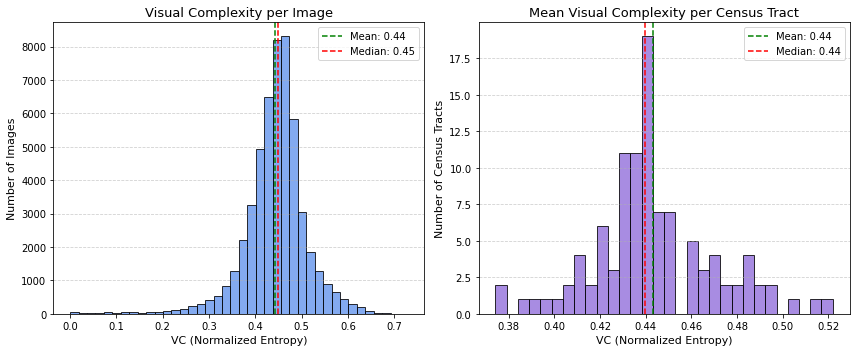

In [247]:
import numpy as np
import matplotlib.pyplot as plt

#  Identify semantic ratio columns
semantic_ratio_columns = [col for col in final_merged_df.columns if "ratio" in col.lower()]
n_categories = len(semantic_ratio_columns)

# Define normalized entropy function
def calculate_normalized_entropy(row):
    values = row.values.astype(float)
    total = np.sum(values)
    if total > 0:
        probabilities = values / total
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-9))  # Natural log
        return entropy / np.log(n_categories)
    else:
        return 0

# Compute VC for each image
final_merged_df["visual_complexity"] = final_merged_df[semantic_ratio_columns].apply(
    calculate_normalized_entropy, axis=1
)

# Aggregate VC by census tract
vc_by_geoid = final_merged_df.groupby("geoid")["visual_complexity"].mean().reset_index()

# Plot VC for all images
plt.figure(figsize=(12, 5))

# Subplot 1: Per image
plt.subplot(1, 2, 1)
vc_image_values = final_merged_df["visual_complexity"]
plt.hist(vc_image_values, bins=40, color="cornflowerblue", edgecolor="black", alpha=0.8)
plt.axvline(vc_image_values.mean(), color="green", linestyle="--", label=f"Mean: {vc_image_values.mean():.2f}")
plt.axvline(vc_image_values.median(), color="red", linestyle="--", label=f"Median: {vc_image_values.median():.2f}")
plt.title("Visual Complexity per Image", fontsize=13)
plt.xlabel("VC (Normalized Entropy)", fontsize=11)
plt.ylabel("Number of Images", fontsize=11)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Subplot 2: Per census tract
plt.subplot(1, 2, 2)
vc_ct_values = vc_by_geoid["visual_complexity"]
plt.hist(vc_ct_values, bins=30, color="mediumpurple", edgecolor="black", alpha=0.8)
plt.axvline(vc_ct_values.mean(), color="green", linestyle="--", label=f"Mean: {vc_ct_values.mean():.2f}")
plt.axvline(vc_ct_values.median(), color="red", linestyle="--", label=f"Median: {vc_ct_values.median():.2f}")
plt.title("Mean Visual Complexity per Census Tract", fontsize=13)
plt.xlabel("VC (Normalized Entropy)", fontsize=11)
plt.ylabel("Number of Census Tracts", fontsize=11)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


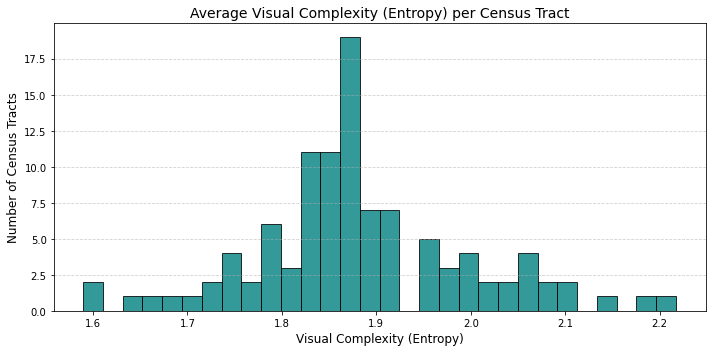

In [245]:

# Aggregate VC by census tract (geoid)
vc_by_geoid = final_merged_df.groupby("geoid")["visual_complexity"].mean().reset_index()

# Plot histogram of average VC per tract
plt.figure(figsize=(10, 5))
plt.hist(vc_by_geoid["visual_complexity"], bins=30, color="teal", edgecolor="black", alpha=0.8)
plt.title("Average Visual Complexity (Entropy) per Census Tract", fontsize=14)
plt.xlabel("Visual Complexity (Entropy)", fontsize=12)
plt.ylabel("Number of Census Tracts", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [6]:
print(final_merged_df["geoid"].count())  # Replace "geoid" with any column name

final_merged_df.head()

52447


,geoid,filename_key,bicycle_count,building_count,bus_count,car_count,fence_count,motorcycle_count,person_count,pole_count,...,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,visual_complexity
0,48201100001,1.152699e+14,0.0,1.0,0.0,8.0,1.0,0.0,0.0,1.0,...,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254,2.109106
1,48201100001,1.239101e+14,0.0,1.0,0.0,11.0,1.0,0.0,1.0,1.0,...,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254,2.014626
2,48201100001,1.282752e+14,0.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0,...,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254,2.221672
3,48201100001,1.300632e+14,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,...,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254,1.908514
4,48201100001,1.313521e+14,0.0,1.0,0.0,7.0,0.0,0.0,1.0,1.0,...,1.527854,-1.168562,0.387418,0.937903,-0.115751,0.859398,-0.825816,0.419859,-0.626254,2.077921


In [66]:
# Reduce the dataframe to only variables of interest 
interested_var = ["geoid", "filename_key", "bus_count", "building_ratio", "car_count", "person_count", "bicycle_count",
                 "visual_complexity", "road_ratio", "sidewalk_ratio"]
inform_df = final_merged_df[interested_var]
inform_df.head()

,geoid,filename_key,bus_count,building_ratio,car_count,person_count,bicycle_count,visual_complexity,road_ratio,sidewalk_ratio
0,48201100001,1.152699e+14,0.0,0.491938,8.0,0.0,0.0,2.109106,0.239896,0.092891
1,48201100001,1.239101e+14,0.0,0.134808,11.0,1.0,0.0,2.014626,0.432462,0.027399
2,48201100001,1.282752e+14,0.0,0.160990,5.0,0.0,0.0,2.221672,0.368864,0.000000
3,48201100001,1.300632e+14,0.0,0.268977,2.0,1.0,0.0,1.908514,0.401136,0.014504
4,48201100001,1.313521e+14,0.0,0.185264,7.0,1.0,0.0,2.077921,0.414818,0.018804


In [67]:
# Save final interested dataset 
output_path = "/Users/etoileboots/Desktop/CAPSTONE/inform_df.csv"
inform_df.to_csv(output_path, index=False)

In [68]:
inform_df = pd.read_csv(output_path)

In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def scale_by_context(df, columns, group_col='geoid'):
    """
    Normalize within the context of a larger group or dataset for comparison.
    This approach centers and scales each column relative to its distribution.
    """
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df


# Scale all relevant features
features_to_scale = [
    "bus_count", "building_ratio", "car_count", "person_count", 
    "bicycle_count", "visual_complexity", "SW_to_road"]
inform_df = inform_df.copy()
inform_df["SW_to_road"] = np.minimum(1, inform_df["sidewalk_ratio"] / inform_df["road_ratio"])

inform_df.head()

,geoid,filename_key,bus_count,building_ratio,car_count,person_count,bicycle_count,visual_complexity,road_ratio,sidewalk_ratio,SW_to_road
0,48201100001,1.152699e+14,0.0,0.491938,8.0,0.0,0.0,2.109106,0.239896,0.092891,0.387214
1,48201100001,1.239101e+14,0.0,0.134808,11.0,1.0,0.0,2.014626,0.432462,0.027399,0.063355
2,48201100001,1.282752e+14,0.0,0.160990,5.0,0.0,0.0,2.221672,0.368864,0.000000,0.000000
3,48201100001,1.300632e+14,0.0,0.268977,2.0,1.0,0.0,1.908514,0.401136,0.014504,0.036157
4,48201100001,1.313521e+14,0.0,0.185264,7.0,1.0,0.0,2.077921,0.414818,0.018804,0.045331


In [70]:
scale_by_context(inform_df, features_to_scale)
inform_df.head() # ratio values will already be scaled between 0 and 1, so their values will not change 

,geoid,filename_key,bus_count,building_ratio,car_count,person_count,bicycle_count,visual_complexity,road_ratio,sidewalk_ratio,SW_to_road
0,48201100001,1.152699e+14,0.0,0.491938,0.363636,0.000000,0.0,0.681418,0.239896,0.092891,0.387214
1,48201100001,1.239101e+14,0.0,0.134808,0.500000,0.066667,0.0,0.650893,0.432462,0.027399,0.063355
2,48201100001,1.282752e+14,0.0,0.160990,0.227273,0.000000,0.0,0.717786,0.368864,0.000000,0.000000
3,48201100001,1.300632e+14,0.0,0.268977,0.090909,0.066667,0.0,0.616610,0.401136,0.014504,0.036157
4,48201100001,1.313521e+14,0.0,0.185264,0.318182,0.066667,0.0,0.671342,0.414818,0.018804,0.045331


In [72]:

# Compute TDI elements
inform_df["U"] = inform_df["building_ratio"]
inform_df["M"] = (inform_df["bus_count"] + inform_df["bicycle_count"] + inform_df["person_count"] + 
                        inform_df["visual_complexity"] + inform_df["SW_to_road"])
inform_df["C"] = inform_df["car_count"]


## Performing Sobol Sensitivity Analysis

In [ ]:
!pip install SALib

In [111]:
import pandas as pd
import numpy as np
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import matplotlib.pyplot as plt

# Define your mobility components
mobility_components = ["bus_count", "bicycle_count", "person_count", "visual_complexity", "SW_to_road"]

# Define Sobol problem
problem = {
    'num_vars': len(mobility_components),
    'names': mobility_components,
    'bounds': [[0, 1]] * len(mobility_components)
}

# Generate Sobol samples and normalize to sum to 1
n_samples = 1024
param_values = sobol.sample(problem, n_samples)
param_values = param_values / param_values.sum(axis=1, keepdims=True)

# Define output function — std of M across geoids
def mobility_variance(weights):
    weights_dict = dict(zip(mobility_components, weights))

    # Compute weighted mobility score
    inform_df["M"] = sum(
        inform_df[comp] * weights_dict[comp] for comp in mobility_components
    )

    # Group by geoid and return std of mean M
    tract_scores = inform_df.groupby("geoid")["M"].mean()
    return tract_scores.std()  # This is spatial variability

# Evaluate across samples
print("Evaluating spatial variance in mobility across samples...")
Y = np.array([mobility_variance(w) for w in param_values])
print("Y summary:", Y.min(), Y.max(), Y.std())

# Sobol analysis
Si = sobol_analyze.analyze(problem, Y, print_to_console=True)

Evaluating spatial variance in mobility across samples...
Y summary: 0.002905238478503103 0.029202558936286618 0.0032985926267817263
                         ST   ST_conf
bus_count          0.165867  0.019725
bicycle_count      0.208744  0.024624
person_count       0.140575  0.014653
visual_complexity  0.377925  0.046140
SW_to_road         0.189151  0.022017
                         S1   S1_conf
bus_count          0.141606  0.033742
bicycle_count      0.182864  0.041764
person_count       0.110418  0.036985
visual_complexity  0.331019  0.054046
SW_to_road         0.141895  0.041755
                                          S2   S2_conf
(bus_count, bicycle_count)          0.003304  0.054738
(bus_count, person_count)           0.003372  0.056274
(bus_count, visual_complexity)     -0.007299  0.050624
(bus_count, SW_to_road)            -0.003169  0.052130
(bicycle_count, person_count)       0.001701  0.061490
(bicycle_count, visual_complexity) -0.003794  0.065241
(bicycle_count, SW_to_road

KeyError: 'names'

| Component         |   S1 (First Order) |   S1_conf |   ST (Total Order) |   ST_conf |
|:------------------|-------------------:|----------:|-------------------:|----------:|
| visual_complexity |              0.331 |     0.054 |              0.378 |     0.046 |
| bicycle_count     |              0.183 |     0.042 |              0.209 |     0.025 |
| bus_count         |              0.142 |     0.034 |              0.166 |     0.02  |
| SW_to_road        |              0.142 |     0.042 |              0.189 |     0.022 |
| person_count      |              0.11  |     0.037 |              0.141 |     0.015 |


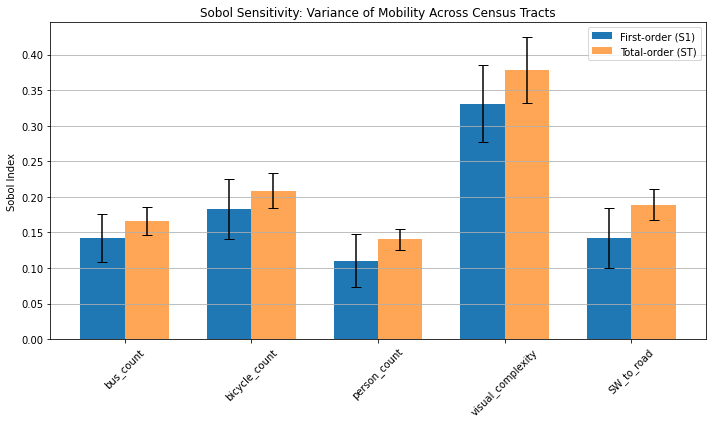

In [113]:

# Tabular summary
summary_df = pd.DataFrame({
    "Component": mobility_components,
    "S1 (First Order)": np.round(Si['S1'], 3),
    "S1_conf": np.round(Si['S1_conf'], 3),
    "ST (Total Order)": np.round(Si['ST'], 3),
    "ST_conf": np.round(Si['ST_conf'], 3)
}).sort_values("S1 (First Order)", ascending=False)

print(summary_df.to_markdown(index=False))

# Plotting results
plt.figure(figsize=(10, 6))
x = np.arange(len(mobility_components))
width = 0.35

plt.bar(x - width/2, Si['S1'], width, yerr=Si['S1_conf'], capsize=5, label='First-order (S1)')
plt.bar(x + width/2, Si['ST'], width, yerr=Si['ST_conf'], capsize=5, label='Total-order (ST)', alpha=0.7)

plt.xticks(x, mobility_components, rotation=45)
plt.ylabel("Sobol Index")
plt.title("Sobol Sensitivity: Variance of Mobility Across Census Tracts")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [117]:
# Set the weights 
mobility_weights = {
    "visual_complexity": 0.3,
    "bicycle_count": 0.2,
    "bus_count": 0.2,
    "SW_to_road": 0.2,
    "person_count": 0.1
inform_df["M"] = sum(
    inform_df[comp] * mobility_weights[comp] for comp in mobility_components
)
spatial_var = inform_df.groupby("geoid")["M"].mean().std()
print("Spatial std of M under chosen weights:", spatial_var)


Spatial std of M under chosen weights: 0.01464879210309598


## Sensitivity analysis of TDI equation weights (with Mobility equation weights fixed)

Evaluating spatial TDI variance across weight samples...
           ST   ST_conf
w_U  0.083668  0.014200
w_M  0.455770  0.046290
w_C  0.541295  0.061266
           S1   S1_conf
w_U  0.025445  0.027642
w_M  0.409076  0.054943
w_C  0.504126  0.060577
                  S2   S2_conf
(w_U, w_M)  0.025604  0.050452
(w_U, w_C)  0.022686  0.048349
(w_M, w_C)  0.008191  0.095788


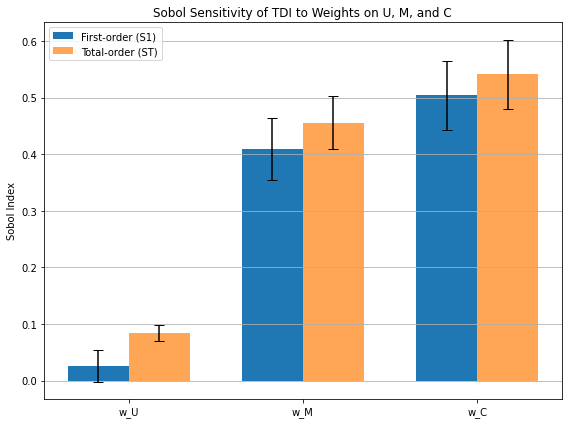

| Component   |   S1 (First Order) |   S1_conf |   ST (Total Order) |   ST_conf |
|:------------|-------------------:|----------:|-------------------:|----------:|
| w_C         |              0.504 |     0.061 |              0.541 |     0.061 |
| w_M         |              0.409 |     0.055 |              0.456 |     0.046 |
| w_U         |              0.025 |     0.028 |              0.084 |     0.014 |


In [118]:
import numpy as np
import pandas as pd
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import matplotlib.pyplot as plt


inform_df["U"] = inform_df["building_ratio"]
inform_df["C"] = inform_df["car_count"]

# Define the problem (3 variables: w_U, w_M, w_C)
tdi_components = ["w_U", "w_M", "w_C"]

problem = {
    'num_vars': 3,
    'names': tdi_components,
    'bounds': [[0, 1]] * 3
}

# Generate samples and normalize to sum to 1
n_samples = 1024
param_values = sobol.sample(problem, n_samples)
param_values = param_values / param_values.sum(axis=1, keepdims=True)

# Define output function = spatial variance of TDI
def tdi_spatial_variance(weights):
    w_U, w_M, w_C = weights
    inform_df["TDI"] = w_U * inform_df["U"] - w_M * inform_df["M"] + w_C * inform_df["C"]
    return inform_df.groupby("geoid")["TDI"].mean().std()

# Evaluate over all samples
print("Evaluating spatial TDI variance across weight samples...")
Y = np.array([tdi_spatial_variance(w) for w in param_values])

# Run Sobol analysis
Si = sobol_analyze.analyze(problem, Y, print_to_console=True)

# Visualize
plt.figure(figsize=(8, 6))
x = np.arange(len(tdi_components))
width = 0.35

plt.bar(x - width/2, Si['S1'], width, yerr=Si['S1_conf'], capsize=5, label='First-order (S1)')
plt.bar(x + width/2, Si['ST'], width, yerr=Si['ST_conf'], capsize=5, label='Total-order (ST)', alpha=0.7)

plt.xticks(x, tdi_components)
plt.ylabel("Sobol Index")
plt.title("Sobol Sensitivity of TDI to Weights on U, M, and C")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Tabular summary
summary_df = pd.DataFrame({
    "Component": tdi_components,
    "S1 (First Order)": np.round(Si['S1'], 3),
    "S1_conf": np.round(Si['S1_conf'], 3),
    "ST (Total Order)": np.round(Si['ST'], 3),
    "ST_conf": np.round(Si['ST_conf'], 3)
}).sort_values("S1 (First Order)", ascending=False)

print(summary_df.to_markdown(index=False))


## Compute Transit Desert Index For Each Image, before aggregating to CT level

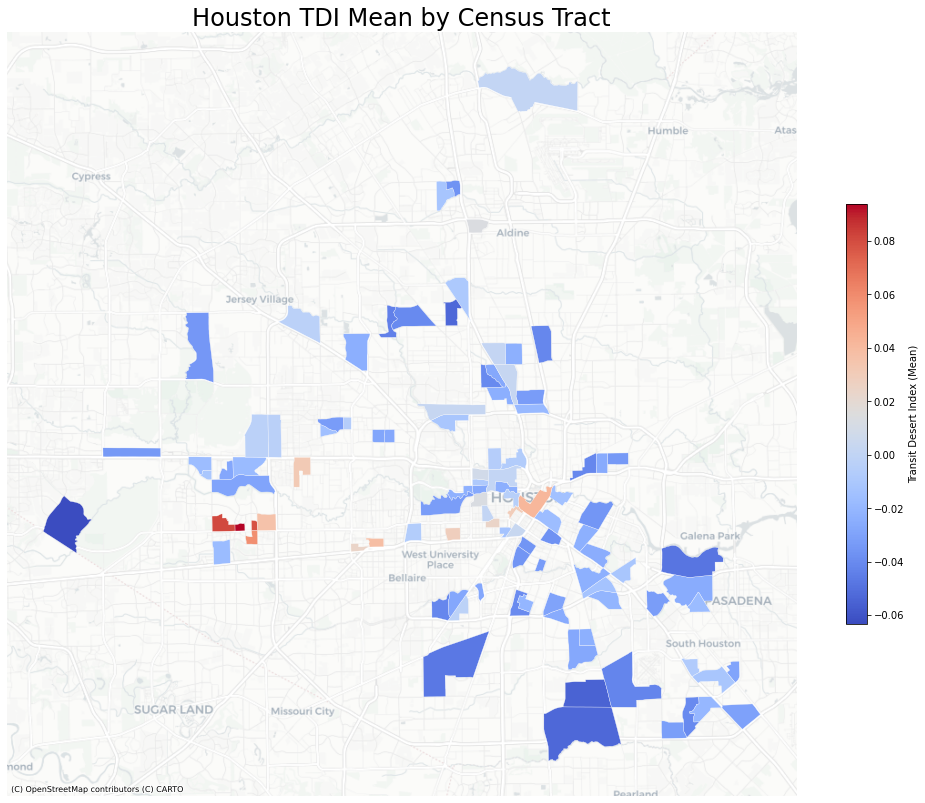

In [132]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Final weights
w_C, w_M, w_U = 0.4, 0.4, 0.2

# Compute TDI for each image
inform_df["TDI"] = (
    w_U * inform_df["U"] - w_M * inform_df["M"] + w_C * inform_df["C"]
)

# Aggregate to tract level (mean and std)
ct_level_tdi = (
    inform_df.groupby("geoid")["TDI"]
    .agg(TDI_mean_CT="mean", TDI_std_CT="std")
    .reset_index()
)

# Load Houston tract shapefile
geojson_path = "/Volumes/MRDALLMAYR/data/geospatial_data/Houston_CT_2022.geojson"
tracts_gdf = gpd.read_file(geojson_path)
tracts_gdf["GEOID"] = tracts_gdf["GEOID"].astype(str)
ct_level_tdi["geoid"] = ct_level_tdi["geoid"].astype(str)

# Merge with TDI values
tracts_merged = tracts_gdf.merge(ct_level_tdi, left_on="GEOID", right_on="geoid")

# Reproject to Web Mercator (required for basemap)
tracts_merged = tracts_merged.to_crs(epsg=3857)
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(figsize=(14, 12))
tracts_merged.plot(
    column="TDI_mean_CT",
    cmap="coolwarm",
    legend=True,
    legend_kwds={"label": "Transit Desert Index (Mean)", "shrink": 0.5},
    edgecolor="white",
    linewidth=0.3,
    ax=ax
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)

plt.title("Houston TDI Mean by Census Tract", fontsize=24)
ax.tick_params(labelsize=12)
ax.set_axis_off()

# Manually change legend text size
legend = ax.get_legend()
if legend:
    legend.set_title("Transit Desert Index (Mean)")
    plt.setp(legend.get_texts(), fontsize=14)
    plt.setp(legend.get_title(), fontsize=16)

plt.tight_layout()
plt.show()

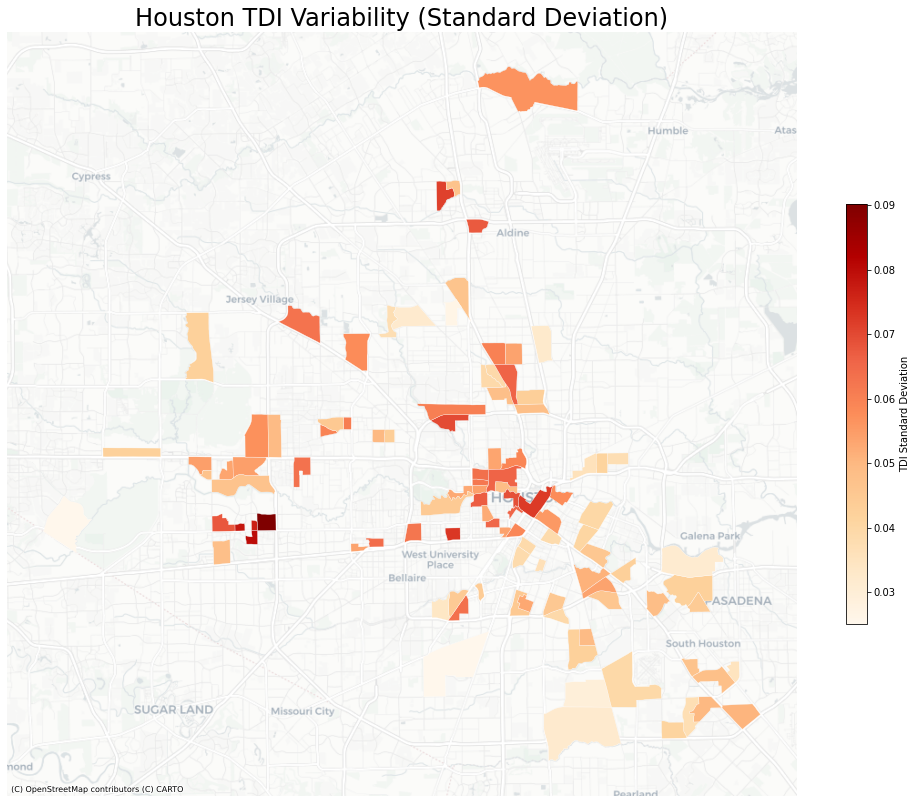

In [139]:
# Plot TDI std dev
fig, ax = plt.subplots(figsize=(14, 12))
tracts_merged.plot(
    column="TDI_std_CT",
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "TDI Standard Deviation", "shrink": 0.5},  # ✅ Removed fontsize
    edgecolor="white",
    linewidth=0.3,
    ax=ax
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)

plt.title("Houston TDI Variability (Standard Deviation)", fontsize=24)

# ✅ Manually update legend font size
legend = ax.get_legend()
if legend:
    legend.set_title("TDI Standard Deviation")
    plt.setp(legend.get_texts(), fontsize=20)
    plt.setp(legend.get_title(), fontsize=20)

plt.axis("off")
plt.tight_layout()
plt.show()


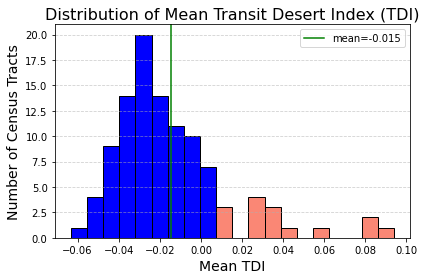

In [151]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors
bar_color_below = "#0000ff"  # blue for ≤ 0
bar_color_above = "#fa8775"  # red for > 0

# Drop NaNs and get data
tdi_data = tracts_merged["TDI_mean_CT"].dropna()

# Create the histogram data
counts, bins, patches = plt.hist(tdi_data, bins=20, edgecolor="black")

# Color bars conditionally
for patch, left_edge in zip(patches, bins[:-1]):
    if left_edge > 0:
        patch.set_facecolor(bar_color_above)
    else:
        patch.set_facecolor(bar_color_below)

# Plot formatting
plt.title("Distribution of Mean Transit Desert Index (TDI)", fontsize=16)
plt.xlabel("Mean TDI", fontsize=14)
plt.ylabel("Number of Census Tracts", fontsize=14)
mean_tdi = round(np.mean(tdi_data), 3)
plt.axvline(x=np.mean(tdi_data), color="green", label=f"mean={mean_tdi}")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Data Comparison to Jiao

In [229]:
# Select and rename columns
my_TDI_metrics = inform_df[["geoid", "TDI"]].rename(columns={"TDI": "my_TDI"})
my_TDI_metrics.head()

,geoid,my_TDI
0,48201100001,0.131095
1,48201100001,0.141119
2,48201100001,0.036973
3,48201100001,0.010607
4,48201100001,0.077471


In [230]:
mean_TDI_by_geoid = my_TDI_metrics.groupby("geoid")["my_TDI"].mean().reset_index()

# Create boolean column for identifying transit deserts
mean_TDI_by_geoid["my_transit_desert"] = mean_TDI_by_geoid["my_TDI"] >= 0

mean_TDI_by_geoid.head()

,geoid,my_TDI,my_transit_desert
0,48201100001,0.042198,True
1,48201211302,-0.041447,False
2,48201211600,-0.026208,False
3,48201211900,-0.033972,False
4,48201220200,-0.019021,False


In [231]:
# Load Jiao data
jiaos_path = "/Users/etoileboots/Desktop/CAPSTONE/jiao_recreation_houson/jiao_TDI.csv"
jiao_df = pd.read_csv(jiaos_path, dtype={"geoid": str})

# Ensure geoids are strings
mean_TDI_by_geoid["geoid"] = mean_TDI_by_geoid["geoid"].astype(str)
jiao_df["geoid"] = jiao_df["geoid"].astype(str)

# Trim Jiao's geoid to census tract level (first 11 digits)
jiao_df["tract_geoid"] = jiao_df["geoid"].str[:11]

# Aggregate Jiao's data to census tract level by averaging
jiao_tract_level = (
    jiao_df.groupby("tract_geoid")[["TDI"]]
    .mean()
    .reset_index()
    .rename(columns={"tract_geoid": "geoid", "TDI": "Jiao_TDI"})
)

# Reclassify transit desert status at tract level for Jiao
jiao_tract_level["Jiao_transit_desert"] = jiao_tract_level["Jiao_TDI"] >= 0

# Merge your metrics with Jiao's aggregated metrics
tdi_merged = mean_TDI_by_geoid.merge(jiao_tract_level, on="geoid", how="left")

# Compute difference and agreement
tdi_merged["TDI_difference"] = tdi_merged["my_TDI"] - tdi_merged["Jiao_TDI"]
tdi_merged["transit_desert_agreement"] = (
    tdi_merged["my_transit_desert"] == tdi_merged["Jiao_transit_desert"]
)

# Preview result
tdi_merged.head()


,geoid,my_TDI,my_transit_desert,Jiao_TDI,Jiao_transit_desert,TDI_difference,transit_desert_agreement
0,48201100001,0.042198,True,-0.326715,False,0.368912,False
1,48201211302,-0.041447,False,-0.140984,False,0.099537,True
2,48201211600,-0.026208,False,-0.101653,False,0.075445,True
3,48201211900,-0.033972,False,0.169254,True,-0.203225,False
4,48201220200,-0.019021,False,-0.248801,False,0.229780,True


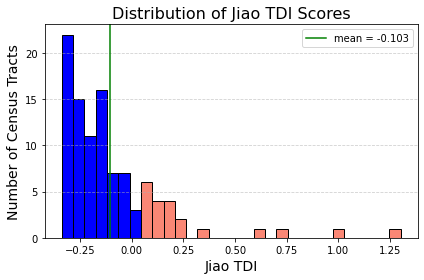

In [241]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors
bar_color_below = "#0000ff"  # blue for ≤ 0
bar_color_above = "#fa8775"  # red for > 0

# Drop NaNs and filter for TDI < 2
tdi_data = tdi_merged["Jiao_TDI"].dropna()
tdi_data = tdi_data[tdi_data < 2]

# Create histogram
counts, bins, patches = plt.hist(tdi_data, bins=30, edgecolor="black")

# Conditionally color each bar
for patch, left_edge in zip(patches, bins[:-1]):
    if left_edge <= 0:
        patch.set_facecolor(bar_color_below)
    else:
        patch.set_facecolor(bar_color_above)

# Plot formatting
plt.title("Distribution of Jiao TDI Scores", fontsize=16)
plt.xlabel("Jiao TDI", fontsize=14)
plt.ylabel("Number of Census Tracts", fontsize=14)

# Mean line
mean_tdi = round(np.mean(tdi_data), 3)
plt.axvline(x=mean_tdi, color="green", label=f"mean = {mean_tdi}")

# Grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


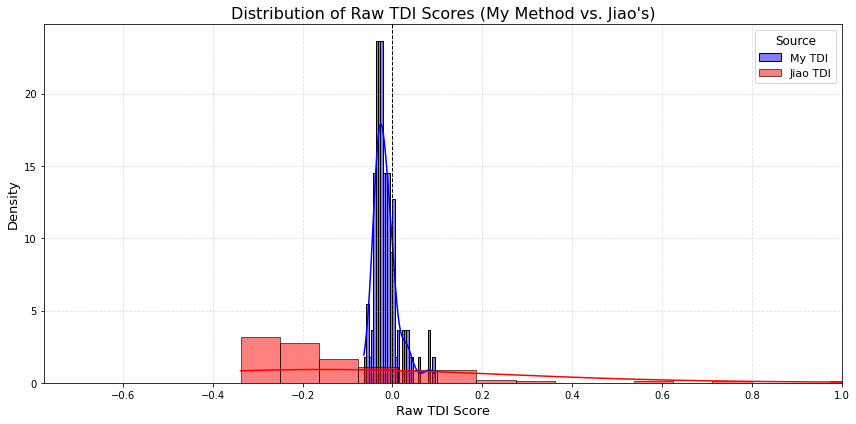

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Plot histograms + KDEs
sns.histplot(tdi_merged["my_TDI"], kde=True, label="My TDI", color="blue", stat="density", alpha=0.5, bins=30)
sns.histplot(tdi_merged["Jiao_TDI"], kde=True, label="Jiao TDI", color="red", stat="density", alpha=0.5, bins=100)

# Styling and limits
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Distribution of Raw TDI Scores (My Method vs. Jiao's)", fontsize=16)
plt.xlabel("Raw TDI Score", fontsize=13)
plt.ylabel("Density", fontsize=13)
plt.xlim(None, 1)  # Truncate at x = 1
plt.legend(title="Source", fontsize=11, title_fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


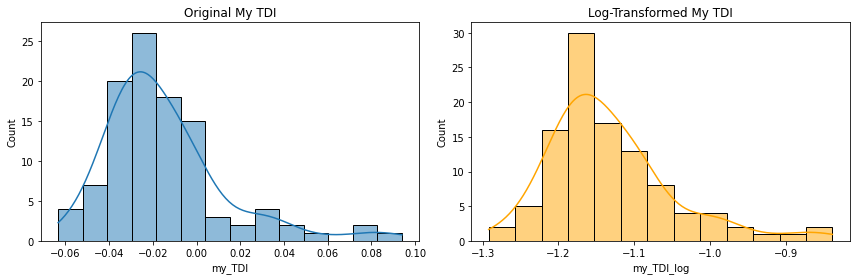

In [223]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Avoid log(0) or log of negative values by shifting
shift = abs(min(tdi_merged["my_TDI"].min(), tdi_merged["Jiao_TDI"].min())) + 1e-6

tdi_log_scaled = tdi_merged.copy()
tdi_log_scaled["my_TDI_log"] = np.log(tdi_log_scaled["my_TDI"] + shift)
tdi_log_scaled["Jiao_TDI_log"] = np.log(tdi_log_scaled["Jiao_TDI"] + shift)

# Then standardize
scaler = StandardScaler()
tdi_log_scaled[["my_TDI_std", "Jiao_TDI_std"]] = scaler.fit_transform(
    tdi_log_scaled[["my_TDI_log", "Jiao_TDI_log"]]
)

# Compute difference
tdi_log_scaled["TDI_std_difference"] = (
    tdi_log_scaled["my_TDI_std"] - tdi_log_scaled["Jiao_TDI_std"]
)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(tdi_merged["my_TDI"], kde=True, ax=axes[0])
axes[0].set_title("Original My TDI")

sns.histplot(tdi_log_scaled["my_TDI_log"], kde=True, ax=axes[1], color="orange")
axes[1].set_title("Log-Transformed My TDI")

plt.tight_layout()
plt.show()


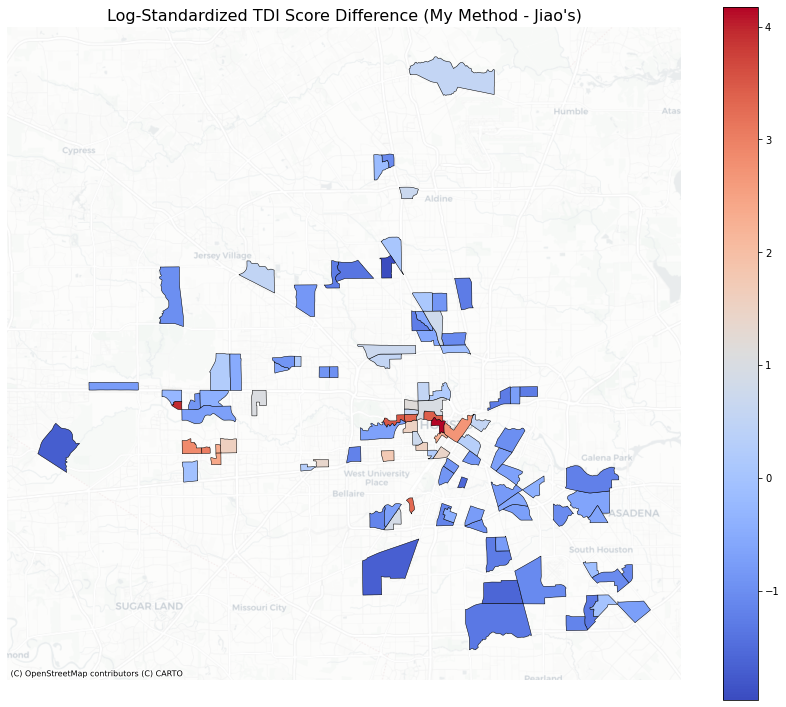

In [244]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # for adding a basemap

# Load Houston Census Tract geometries
geojson_path = "/Volumes/MRDALLMAYR/data/geospatial_data/Houston_CT_2022.geojson"
gdf = gpd.read_file(geojson_path)

# Ensure matching formats for merge
gdf["GEOID20"] = gdf["GEOID"].astype(str)
tdi_log_scaled["geoid"] = tdi_log_scaled["geoid"].astype(str)

# Merge TDI data with geometries
comparison_map_gdf = gdf.merge(tdi_log_scaled, left_on="GEOID20", right_on="geoid")

# Reproject to Web Mercator for basemap compatibility
comparison_map_gdf = comparison_map_gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
comparison_map_gdf.plot(
    column="TDI_std_difference",
    cmap="coolwarm",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.5)

# Format
ax.set_title("Log-Standardized TDI Score Difference (My Method - Jiao's)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


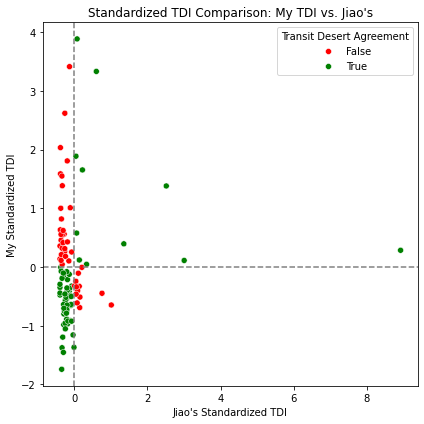

In [212]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=tdi_for_scaling,
    x="J",
    y="my_TDI_std",
    hue="transit_desert_agreement",
    palette={True: "green", False: "red"}
)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Standardized TDI Comparison: My TDI vs. Jiao's")
plt.xlabel("Jiao's Standardized TDI")
plt.ylabel("My Standardized TDI")
plt.legend(title="Transit Desert Agreement")
plt.tight_layout()
plt.show()


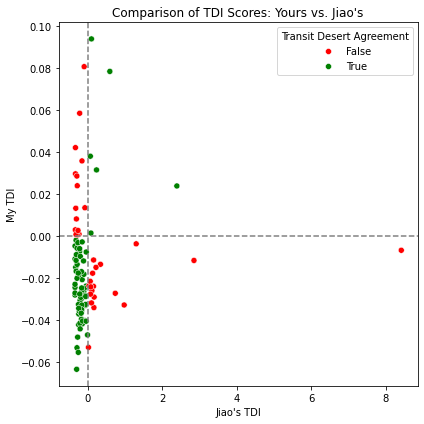

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(data=tdi_merged, x="Jiao_TDI", y="my_TDI", hue="transit_desert_agreement", palette={True: "green", False: "red"})
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.title("Comparison of TDI Scores: Yours vs. Jiao's")
plt.xlabel("Jiao's TDI")
plt.ylabel("My TDI")
plt.legend(title="Transit Desert Agreement")
plt.tight_layout()
plt.show()


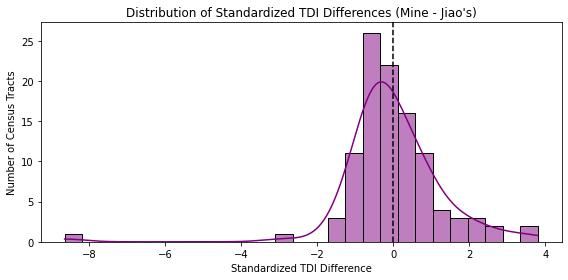

In [213]:
plt.figure(figsize=(8, 4))
sns.histplot(tdi_for_scaling["TDI_std_difference"], kde=True, color="purple")
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribution of Standardized TDI Differences (Mine - Jiao's)")
plt.xlabel("Standardized TDI Difference")
plt.ylabel("Number of Census Tracts")
plt.tight_layout()
plt.show()


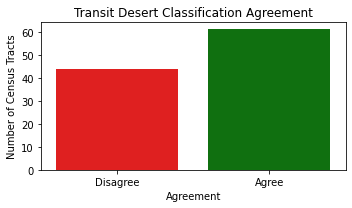

In [216]:

tdi_for_scaling["transit_desert_agreement"] = tdi_for_scaling["transit_desert_agreement"].astype(bool)
plt.figure(figsize=(5, 3))
sns.countplot(
    x="transit_desert_agreement",
    data=tdi_for_scaling,
    hue="transit_desert_agreement",
    palette={True: "green", False: "red"},
    legend=False  # legend is redundant since x is also hue
)
plt.title("Transit Desert Classification Agreement")
plt.xlabel("Agreement")
plt.ylabel("Number of Census Tracts")
plt.xticks([0, 1], ["Disagree", "Agree"])
plt.tight_layout()
plt.show()
